In [11]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings("ignore")

In [12]:
TICKER = "BBNI.JK"
start_date_BBNI = "2023-01-01"
end_date_BBNI = pd.to_datetime("today").strftime("%Y-%m-%d")

df = yf.download(TICKER, start=start_date_BBNI, end=end_date_BBNI)['Close']

print(f"Data BBNI.JK ({len(df)} days):")
print(df.tail())

[*********************100%***********************]  1 of 1 completed

Data BBNI.JK (675 days):
Ticker      BBNI.JK
Date               
2025-10-30   4410.0
2025-10-31   4380.0
2025-11-03   4430.0
2025-11-04   4450.0
2025-11-05   4460.0


Auto ARIMA

In [13]:
model_auto = pm.auto_arima(df, 
                           suppress_warnings=True, 
                           stepwise=True, 
                           seasonal=False,
                           error_action='ignore'
                           )

print("\nbest parameters ARIMA (p,d,q): ")
print(model_auto.order)

p, d, q = model_auto.order


best parameters ARIMA (p,d,q): 
(0, 1, 2)


Split data tarining and testing

In [14]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

print(f"\nData Training: {len(train_data)} days")
print(f"Data Testing: {len(test_data)} days")


Data Training: 540 days
Data Testing: 135 days


Build and fit ARIMA Model

In [15]:
model_manual = ARIMA(train_data, order=(p, d, q))
model_manual_fit = model_manual.fit()

print(model_manual_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                BBNI.JK   No. Observations:                  540
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -3134.384
Date:                Thu, 06 Nov 2025   AIC                           6274.767
Time:                        12:42:36   BIC                           6287.636
Sample:                             0   HQIC                          6279.801
                                - 540                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0994      0.038      2.583      0.010       0.024       0.175
ma.L2         -0.0748      0.036     -2.078      0.038      -0.145      -0.004
sigma2      6584.6846    293.374     22.445      0.0

Prediction on data testing

In [16]:
predictions = model_manual_fit.forecast(steps=len(test_data))
predictions_series = pd.Series(predictions, index=test_data.index)

print(predictions_series.head())

Date
2025-04-16   NaN
2025-04-17   NaN
2025-04-21   NaN
2025-04-22   NaN
2025-04-23   NaN
Name: predicted_mean, dtype: float64


Evaluate model

In [17]:
mse = mean_squared_error(test_data, predictions)
mae = mean_absolute_error(test_data, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_data, predictions)

print("\n=== Evaluasi Model ARIMA ===")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


=== Evaluasi Model ARIMA ===
MSE: 38389.10
RMSE: 195.93
MAE: 173.53
R² Score: -0.0704


Data Visualisation ARIMA

In [18]:
n_periods = 10 # forecast for the next 10 days
future_predictions = model_manual_fit.forecast(steps=n_periods)

# create future dates
last_date = df.index[-1]
future_dates = [last_date + pd.Timedelta(days=i+1) for i in range(n_periods)]
future_series = pd.Series(future_predictions, index=future_dates)

forecast_table = pd.DataFrame({
    'Date': future_dates,
    'Price Forecast': future_predictions
})

forecast_table['Date'] = forecast_table['Date'].dt.strftime('%Y-%m-%d')
print(forecast_table.to_string(index=False))

      Date  Price Forecast
2025-11-06     4278.340898
2025-11-07     4271.099480
2025-11-08     4271.099480
2025-11-09     4271.099480
2025-11-10     4271.099480
2025-11-11     4271.099480
2025-11-12     4271.099480
2025-11-13     4271.099480
2025-11-14     4271.099480
2025-11-15     4271.099480


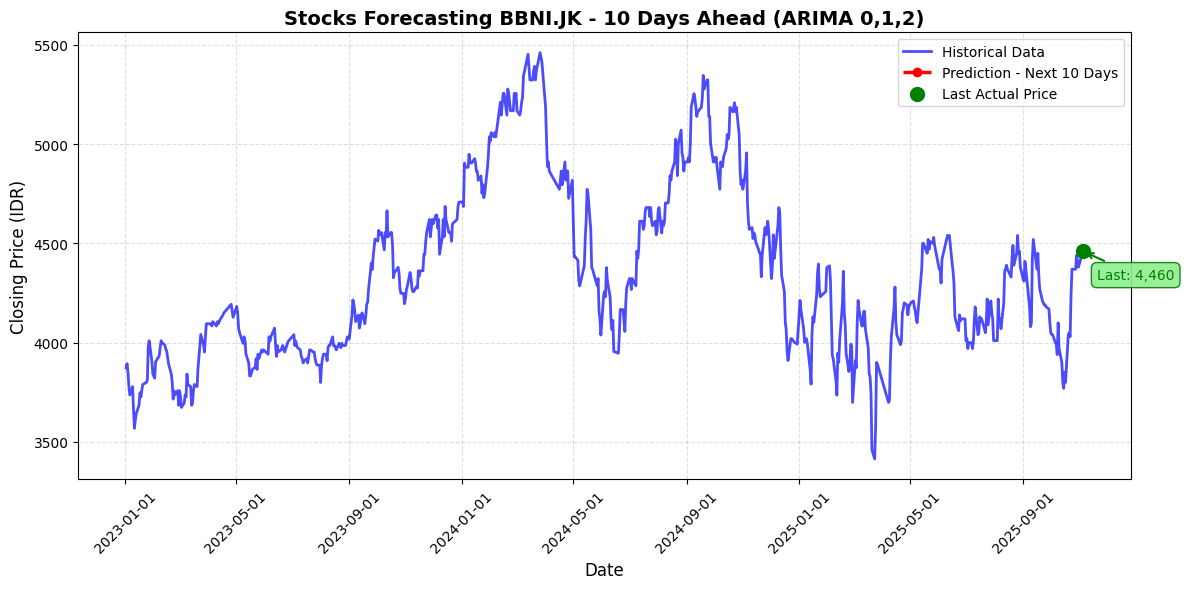

In [19]:
# Visualisation ARIMA
plt.figure(figsize=(12, 6))

# plot historical data and predictions for next 10 days
plt.plot(df.index, df, label='Historical Data', color='blue', linewidth=2, alpha=0.7)
plt.plot(future_series.index, future_series, label='Prediction - Next 10 Days', color='red', linewidth=2.5, linestyle='--', marker='o', markersize=6)

# annotation - PERBAIKAN: gunakan .values untuk iterasi
for date, value in zip(future_series.index, future_series.values):
    plt.annotate(
        f'{value:,.0f}',
        xy=(date, value),
        xytext=(0, 10),
        textcoords='offset points',
        ha='center',
        fontsize=9,
        color='red',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', alpha=0.8)
    )

# highlight mark for last historical data point
last_actual_date = df.index[-1]
last_actual_value = float(df.iloc[-1])
plt.scatter(last_actual_date, last_actual_value, 
            color='green', s=100, zorder=5, label='Last Actual Price')
plt.annotate(
    f'Last: {last_actual_value:,.0f}',
    xy=(last_actual_date, last_actual_value),
    xytext=(10, -20),
    textcoords='offset points',
    fontsize=10,
    color='green',
    bbox=dict(boxstyle='round,pad=0.4', fc='lightgreen', ec='green', alpha=0.9),
    arrowprops=dict(arrowstyle='->', color='green', lw=1.5)
)

plt.title(f'Stocks Forecasting {TICKER} - 10 Days Ahead (ARIMA {p},{d},{q})', 
          fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price (IDR)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Statistics reporting

In [20]:
print(f"Highest Price Prediction: Rp {future_predictions.max():,.0f}")
print(f"Lowest Price Prediction: Rp {future_predictions.min():,.0f}")
print(f"Average Prediction: Rp {future_predictions.mean():,.0f}")
print(f"Last Actual Price: Rp {last_actual_value:,.0f}")
print(f"Change (Last vs Avg Prediction): {((future_predictions.mean() - last_actual_value) / last_actual_value * 100):.2f}%")

Highest Price Prediction: Rp 4,278
Lowest Price Prediction: Rp 4,271
Average Prediction: Rp 4,272
Last Actual Price: Rp 4,460
Change (Last vs Avg Prediction): -4.22%
